In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
import re
import os

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv(r"/content/Restaurant_reviews_cleaned.csv")

print(f"Dataset shape : {df.shape}")
print(f"Feature names : {df.columns.values}")

Dataset shape : (9962, 6)
Feature names : ['Restaurant' 'Reviewer' 'Review' 'Rating' 'label' 'Feedback']


In [ ]:
df.isnull().sum()

,0
Restaurant,0
Reviewer,0
Review,7
Rating,0
label,0
Feedback,0


In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

,0
Restaurant,0
Reviewer,0
Review,0
Rating,0
label,0
Feedback,0


In [ ]:
df['length'] = df['Review'].apply(len)
df.head()

,Restaurant,Reviewer,Review,Rating,label,Feedback,length
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,2,Excellent experience. Keep up the great service!,222
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,2,Excellent experience. Keep up the great service!,144
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,2,Excellent experience. Keep up the great service!,189
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,2,Excellent experience. Keep up the great service!,148
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,2,Excellent experience. Keep up the great service!,160


In [ ]:
print(f"reviews column comment: {df.iloc[13]['Review']}")
print(f"Length of review : {len(df.iloc[13]['Review'])}")
print(f"'length' column value : {df.iloc[13]['length']}")

reviews column comment: Food is too good. Telangana kodiak fry is must try.Mutton biriyani is too good.Papiya helped to choose best dishes and attended very well.Must visit.
Length of review : 149
'length' column value : 149


In [ ]:
df.dtypes

,0
Restaurant,object
Reviewer,object
Review,object
Rating,int64
label,int64
Feedback,object
length,int64


In [ ]:
print(f"Restaurant value count: \n{df['Restaurant'].value_counts()}")

Restaurant value count: 
Restaurant
Beyond Flavours                   100
Paradise                          100
Flechazo                          100
Shah Ghouse Hotel & Restaurant    100
Over The Moon Brew Company        100
                                 ... 
Olive Garden                       99
Domino's Pizza                     99
Hyderabad Chefs                    98
Arena Eleven                       85
American Wild Wings                77
Name: count, Length: 100, dtype: int64


In [ ]:
restaurants_to_drop = ['Arena Eleven', 'American Wild Wings']
indices_to_drop = df[df['Restaurant'].isin(restaurants_to_drop)].index
df = df.drop(indices_to_drop)

In [ ]:
print(f"Dataset shape after dropping specific restaurants: {df.shape}")
print(f"Restaurant value count after dropping: \n{df['Restaurant'].value_counts()}")

Dataset shape after dropping specific restaurants: (9793, 7)
Restaurant value count after dropping: 
Restaurant
Beyond Flavours                   100
Paradise                          100
Flechazo                          100
Shah Ghouse Hotel & Restaurant    100
Over The Moon Brew Company        100
                                 ... 
Being Hungry                       99
Domino's Pizza                     99
Olive Garden                       99
Al Saba Restaurant                 99
Hyderabad Chefs                    98
Name: count, Length: 98, dtype: int64


In [ ]:
df_limited = df.groupby('Restaurant').head(95).reset_index(drop=True)
print(f"\nDataset shape after limiting reviews per restaurant: {df_limited.shape}")
print(f"Restaurant value count after limiting: \n{df_limited['Restaurant'].value_counts()}")

df = df_limited


Dataset shape after limiting reviews per restaurant: (9310, 7)
Restaurant value count after limiting: 
Restaurant
Beyond Flavours                    95
Paradise                           95
Flechazo                           95
Shah Ghouse Hotel & Restaurant     95
Over The Moon Brew Company         95
                                   ..
Desi Bytes                         95
Hyderabadi Daawat                  95
Zega - Sheraton Hyderabad Hotel    95
Triptify                           95
Chinese Pavilion                   95
Name: count, Length: 98, dtype: int64


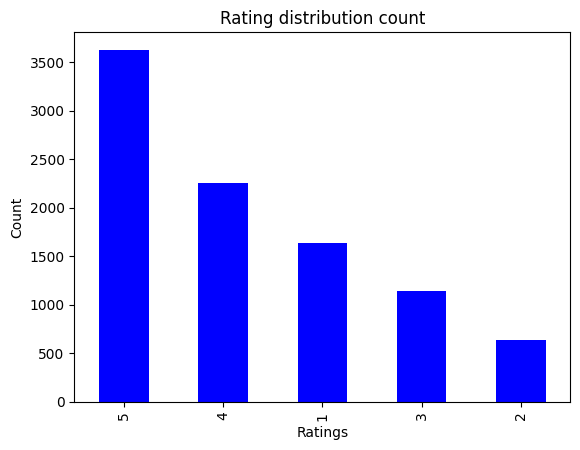

Rating value count - percentage distribution: 
Rating
5    38.98
4    24.27
1    17.60
3    12.26
2     6.89
Name: count, dtype: float64


In [ ]:
df['Rating'].value_counts().plot.bar(color = 'blue')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

print(f"Rating value count - percentage distribution: \n{round(df['Rating'].value_counts()/df.shape[0]*100,2)}")

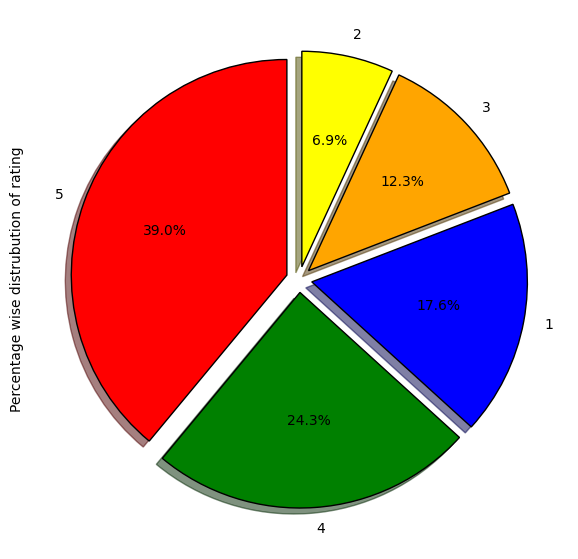

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue','orange','yellow')
wp = {'linewidth':1, "edgecolor":'black'}
tags = df['Rating'].value_counts()/df.shape[0]
explode=(0.06,0.06,0.06,0.06,0.06)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90,
wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')
plt.show()

In [ ]:
print(f"Feedback value count: \n{df['label'].value_counts()}")

Feedback value count: 
label
2    5889
0    2280
1    1141
Name: count, dtype: int64


In [ ]:
print(f"Label value counts:\n{df['label'].value_counts()}")

review_0 = df[df['label'] == 0].iloc[0]['Review']
print(f"\nExample negative review: {review_0}")

review_1 = df[df['label'] == 1].iloc[1]['Review']
print(f"Example neutral review: {review_1}")

review_2 = df[df['label'] == 2].iloc[1]['Review']
print(f"Example positive review: {review_2}")

Label value counts:
label
2    5889
0    2280
1    1141
Name: count, dtype: int64

Example negative review: We ordered corn cheese balls, manchow soup and paneer shashlik sizzler. The sizzler was stale. Paneer was smelling and the waiter was so impolite to even accept the mistake. Never going again
Example neutral review: The reason for giving only a 3 star is because of the longlong time wait for the tables. We went on Friday afternoon. We waited almost more than 30mins to get a table. We lost our patience and left for another restaurant as v didn't get a table even aftr waiting for such a long time.I think restaurant management should take this into consideration and try to decrease the waiting time of customer.
Example positive review: Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service


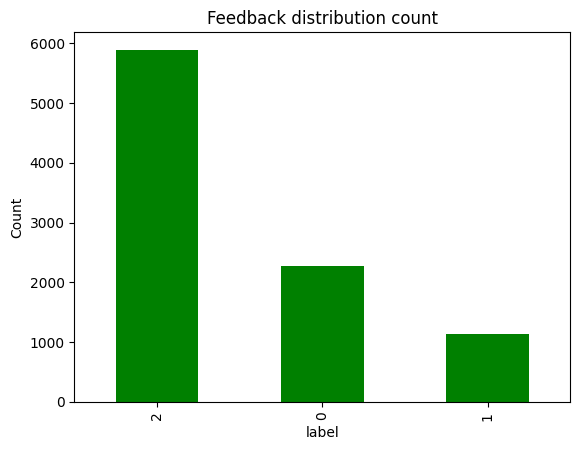

In [ ]:
df['label'].value_counts().plot.bar(color = 'green')
plt.title('Feedback distribution count')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [ ]:
print(f"Label value count - percentage distribution: \n{round(df['label'].value_counts()/df.shape[0]*100,2)}")

Label value count - percentage distribution: 
label
2    63.25
0    24.49
1    12.26
Name: count, dtype: float64


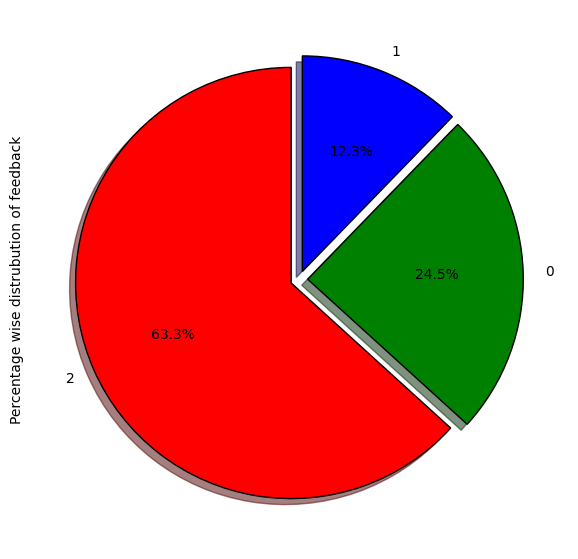

In [ ]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':1, "edgecolor":'black'}
tags = df['label'].value_counts()/df.shape[0]
explode=(0.04,0.04,0.04)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')
plt.show()

In [ ]:
print("\nRating distribution for label 0 (Negative):\n", df[df['label'] == 0]['Rating'].value_counts())
print("\nRating distribution for label 1 (Neutral):\n", df[df['label'] == 1]['Rating'].value_counts())
print("\nRating distribution for label 2 (Positive):\n", df[df['label'] == 2]['Rating'].value_counts())


Rating distribution for label 0 (Negative):
 Rating
1    1639
2     641
Name: count, dtype: int64

Rating distribution for label 1 (Neutral):
 Rating
3    1141
Name: count, dtype: int64

Rating distribution for label 2 (Positive):
 Rating
5    3629
4    2260
Name: count, dtype: int64


In [ ]:
print(f"\nRestaurant value count: \n{df['Restaurant'].value_counts()}")


Restaurant value count: 
Restaurant
Beyond Flavours                    95
Paradise                           95
Flechazo                           95
Shah Ghouse Hotel & Restaurant     95
Over The Moon Brew Company         95
                                   ..
Desi Bytes                         95
Hyderabadi Daawat                  95
Zega - Sheraton Hyderabad Hotel    95
Triptify                           95
Chinese Pavilion                   95
Name: count, Length: 98, dtype: int64


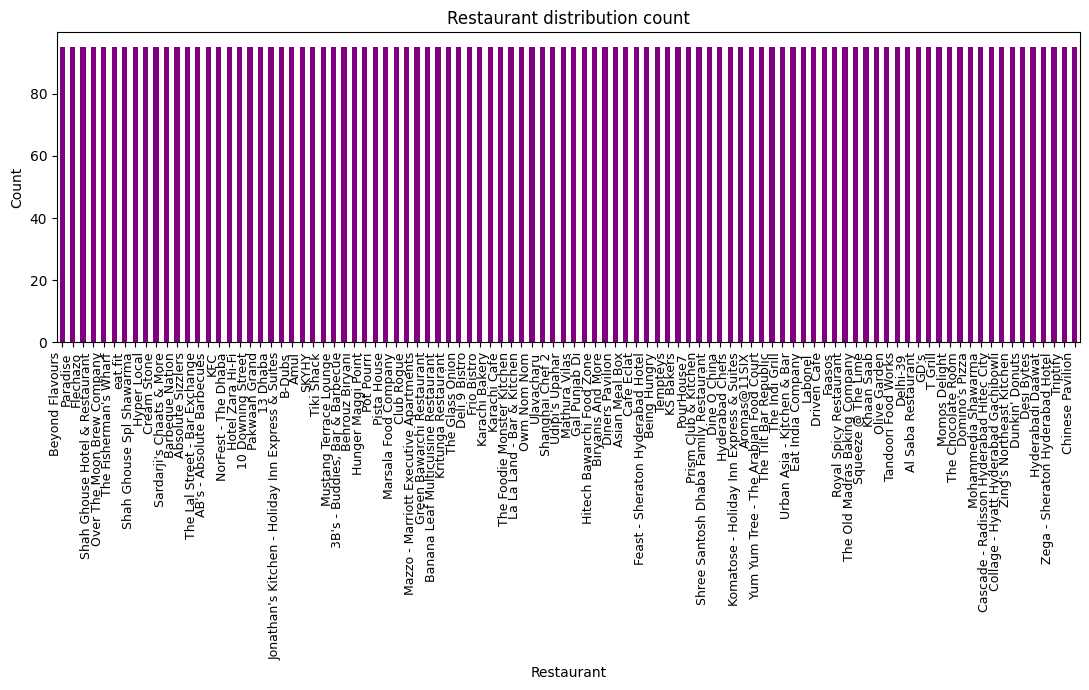

Restaurant value count - percentage distribution: 
Restaurant
Beyond Flavours                    1.02
Paradise                           1.02
Flechazo                           1.02
Shah Ghouse Hotel & Restaurant     1.02
Over The Moon Brew Company         1.02
                                   ... 
Desi Bytes                         1.02
Hyderabadi Daawat                  1.02
Zega - Sheraton Hyderabad Hotel    1.02
Triptify                           1.02
Chinese Pavilion                   1.02
Name: count, Length: 98, dtype: float64


In [ ]:
df['Restaurant'].value_counts().plot.bar(color = 'purple', figsize=(11, 7))
plt.title('Restaurant distribution count')
plt.xlabel('Restaurant')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.tight_layout()
plt.show()
print(f"Restaurant value count - percentage distribution: \n{round(df['Restaurant'].value_counts()/df.shape[0]*100,2)}")

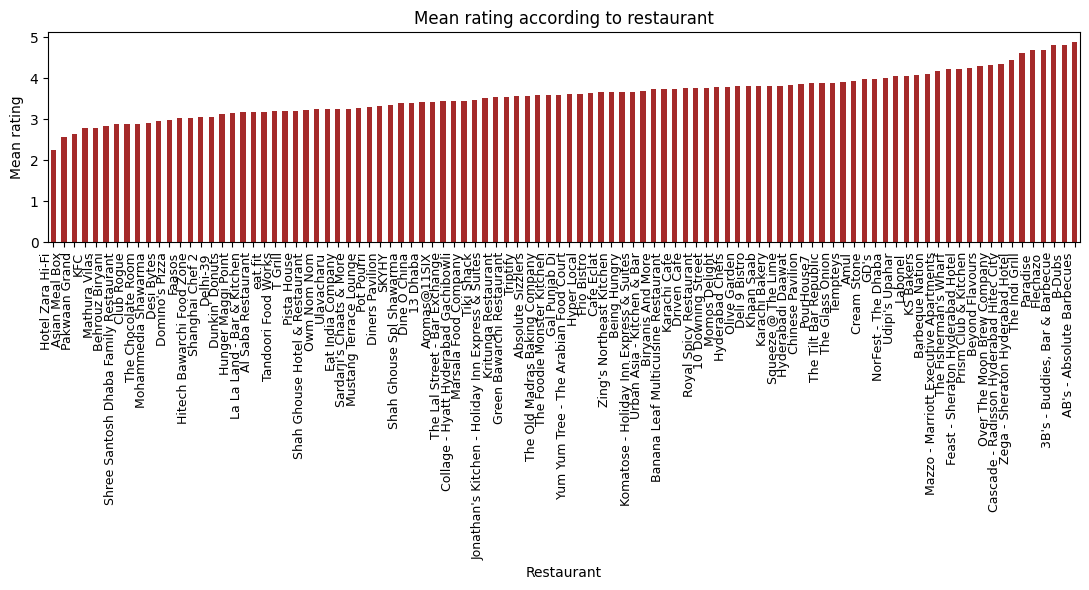

In [ ]:
df.groupby('Restaurant')['Rating'].mean()
df.groupby('Restaurant')['Rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to restaurant")
plt.ylabel('Mean rating')
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Distribution of length of review')]

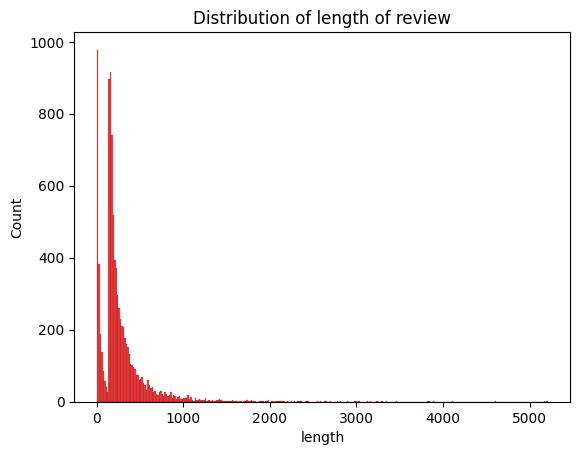

In [ ]:
sns.histplot(df['length'],color='red').set(title='Distribution of length of review')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

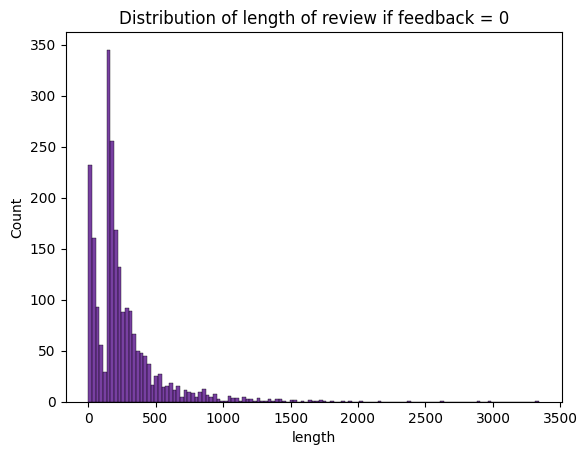

In [ ]:
sns.histplot(df[df['label']==0]['length'],color='indigo').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

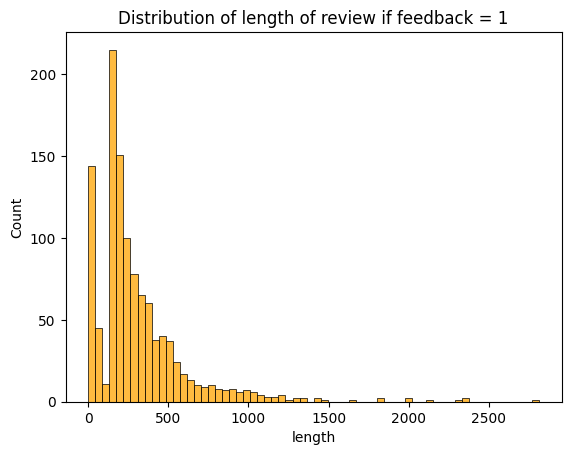

In [ ]:
sns.histplot(df[df['label']==1]['length'],color='orange').set(title='Distribution of length of review if feedback = 1')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 2')]

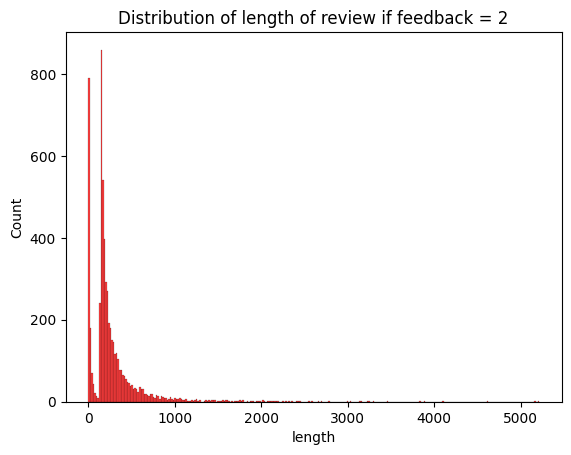

In [ ]:
sns.histplot(df[df['label']==2]['length'],color='red').set(title='Distribution of length of review if feedback = 2')

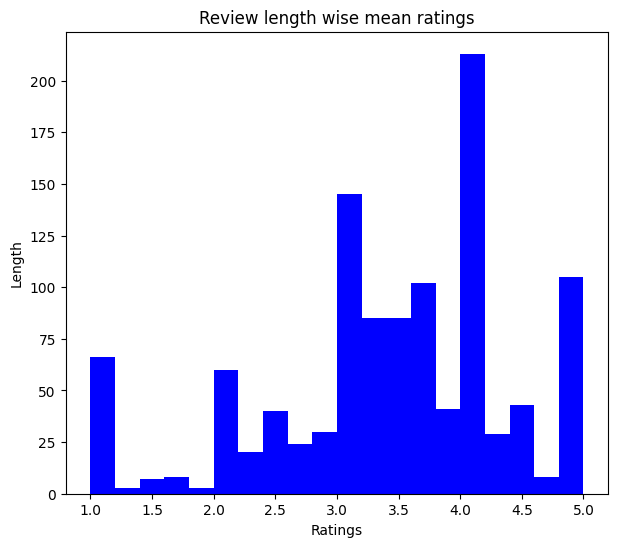

In [ ]:
df.groupby('length')['Rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title("Review length wise mean ratings")
plt.xlabel('Ratings')
plt.ylabel('Length')
plt.show()

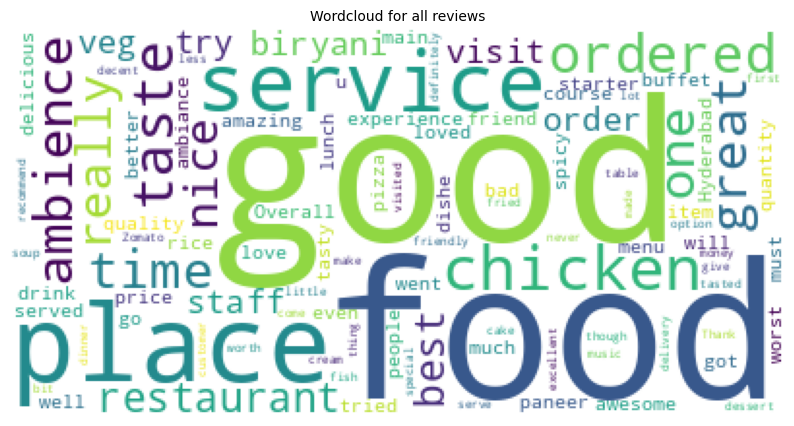

In [ ]:
from wordcloud import WordCloud

reviews_all = " ".join([review for review in df['Review']])
wc_all = WordCloud(background_color='white', max_words=100, collocations=False)
plt.figure(figsize=(10,10))
plt.imshow(wc_all.generate(reviews_all))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
neg_reviews_text = " ".join([review for review in df[df['label'] == 0]['Review']])
neu_reviews_text = " ".join([review for review in df[df['label'] == 1]['Review']])
pos_reviews_text = " ".join([review for review in df[df['label'] == 2]['Review']])

In [ ]:
def get_unique_words(main_text, compare_texts):
    main_words = set(main_text.lower().split())
    for compare_text in compare_texts:
        main_words = main_words - set(compare_text.lower().split())
    return " ".join(list(main_words))

In [ ]:
unique_negative_words = get_unique_words(neg_reviews_text, [neu_reviews_text, pos_reviews_text])
unique_neutral_words = get_unique_words(neu_reviews_text, [neg_reviews_text, pos_reviews_text])
unique_positive_words = get_unique_words(pos_reviews_text, [neg_reviews_text, neu_reviews_text])

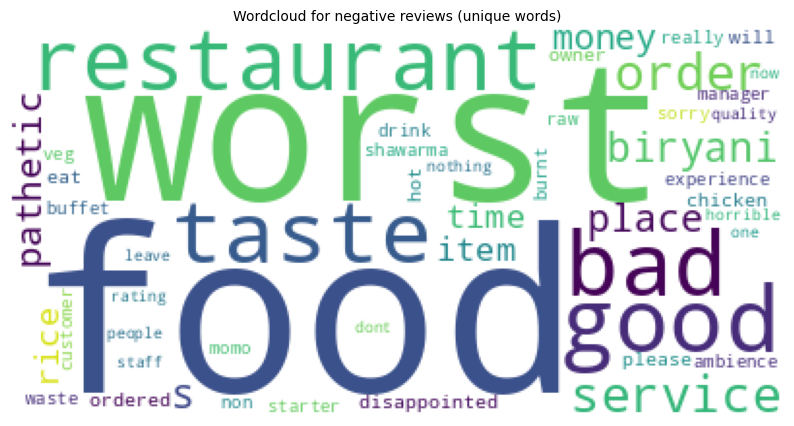

In [ ]:
wc_neg = WordCloud(background_color='white', max_words=50, collocations=False)
plt.figure(figsize=(10,10))
plt.imshow(wc_neg.generate(unique_negative_words))
plt.title('Wordcloud for negative reviews (unique words)', fontsize=10)
plt.axis('off')
plt.show()

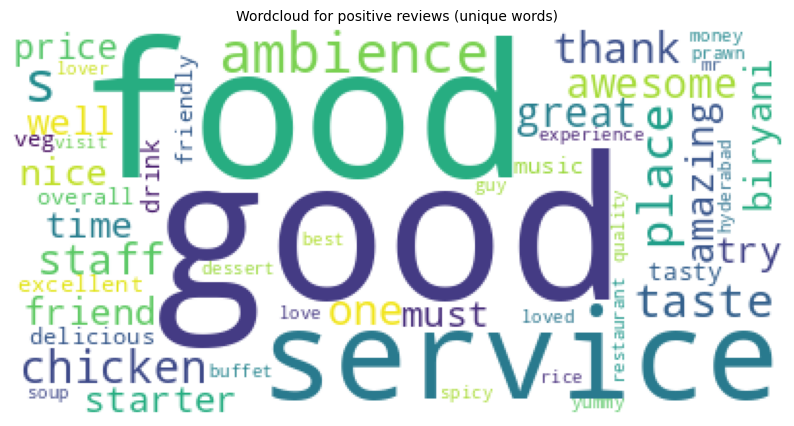

In [ ]:
wc_pos = WordCloud(background_color='white', max_words=50, collocations=False)
plt.figure(figsize=(10,10))
plt.imshow(wc_pos.generate(unique_positive_words))
plt.title('Wordcloud for positive reviews (unique words)', fontsize=10)
plt.axis('off')
plt.show()

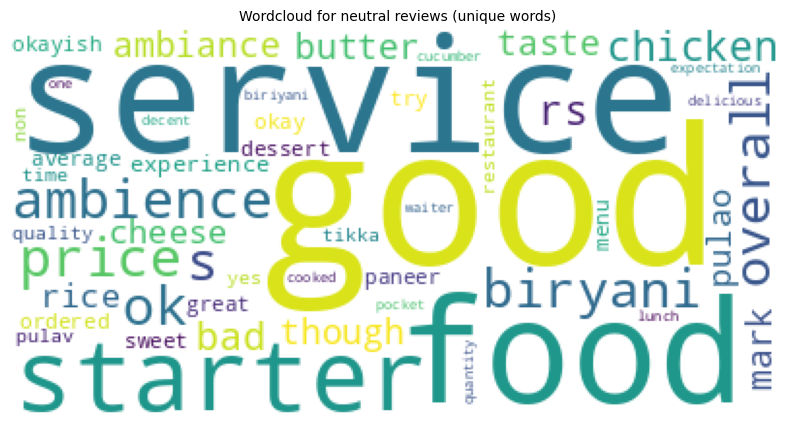

In [ ]:
wc_neu = WordCloud(background_color='white', max_words=50, collocations=False)
plt.figure(figsize=(10,10))
plt.imshow(wc_neu.generate(unique_neutral_words))
plt.title('Wordcloud for neutral reviews (unique words)', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z']", " ", str(text))
    text = text.lower()
    return text

In [ ]:
df['cleaned_review'] = df['Review'].apply(clean_text)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import io
import contextlib

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

In [ ]:
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
padded = pad_sequences(sequences, maxlen=max_len)

In [ ]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [ ]:
def build_lstm():
    model = Sequential([
        Embedding(max_words, 64, input_length=max_len),
        LSTM(64),
        Dropout(0.5),
        Dense(3, activation='softmax')])
    return model

def build_bilstm():
    model = Sequential([
        Embedding(max_words, 64, input_length=max_len),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(3, activation='softmax')])
    return model

def build_bigru():
    model = Sequential([
        Embedding(max_words, 64, input_length=max_len),
        Bidirectional(GRU(64)),
        Dropout(0.5),
        Dense(3, activation='softmax')])
    return model

In [ ]:
def compile_and_train(model, name, X_train, y_train, X_test, y_test):
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(patience=2, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, callbacks=[es], verbose=0)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return acc, model

In [ ]:
trained_models = {}

In [ ]:
acc_lstm, model_lstm = compile_and_train(build_lstm(), "LSTM", X_train_dl, y_train_dl, X_test_dl, y_test_dl)
trained_models["LSTM"] = model_lstm

acc_bilstm, model_bilstm = compile_and_train(build_bilstm(), "BiLSTM", X_train_dl, y_train_dl, X_test_dl, y_test_dl)
trained_models["BiLSTM"] = model_bilstm

acc_bigru, model_bigru = compile_and_train(build_bigru(), "BiGRU", X_train_dl, y_train_dl, X_test_dl, y_test_dl)
trained_models["BiGRU"] = model_bigru

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Accuracy: 0.8502
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       436
           1       0.49      0.36      0.41       211
           2       0.91      0.93      0.92      1215

    accuracy                           0.85      1862
   macro avg       0.73      0.72      0.72      1862
weighted avg       0.84      0.85      0.84      1862



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
BiLSTM Accuracy: 0.8539
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       436
           1       0.58      0.14      0.23       211
           2       0.90      0.95      0.92      1215

    accuracy                           0.85      1862
   macro avg       0.75      0.67      0.66      1862
weighted avg       0.83      0.85      0.83      1862



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
BiGRU Accuracy: 0.8496
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       436
           1       0.48      0.32      0.38       211
           2       0.90      0.94      0.92      1215

    accuracy                           0.85      1862
   macro avg       0.73      0.71      0.71      1862
weighted avg       0.83      0.85      0.84      1862



In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['cleaned_review'])
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_ml, y_train_ml)
lr_pred = lr.predict(X_test_ml)
acc_lr = accuracy_score(y_test_ml, lr_pred)
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(classification_report(y_test_ml, lr_pred))
trained_models["Logistic Regression"] = lr

lasso_lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso_lr.fit(X_train_ml, y_train_ml)
lasso_pred = lasso_lr.predict(X_test_ml)
acc_lasso = accuracy_score(y_test_ml, lasso_pred)
print(f"Lasso Regression Accuracy: {acc_lasso:.4f}")
print(classification_report(y_test_ml, lasso_pred))
trained_models["Lasso Regression"] = lasso_lr

Logistic Regression Accuracy: 0.8534
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       436
           1       0.59      0.19      0.29       211
           2       0.87      0.97      0.92      1215

    accuracy                           0.85      1862
   macro avg       0.76      0.67      0.68      1862
weighted avg       0.83      0.85      0.83      1862

Lasso Regression Accuracy: 0.8389
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       436
           1       0.49      0.16      0.24       211
           2       0.87      0.96      0.91      1215

    accuracy                           0.84      1862
   macro avg       0.72      0.65      0.66      1862
weighted avg       0.81      0.84      0.81      1862



In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_ml, y_train_ml)
rf_pred = rf.predict(X_test_ml)
acc_rf = accuracy_score(y_test_ml, rf_pred)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(classification_report(y_test_ml, rf_pred))
trained_models["Random Forest"] = rf

Random Forest Accuracy: 0.8260
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       436
           1       0.43      0.03      0.05       211
           2       0.83      0.98      0.90      1215

    accuracy                           0.83      1862
   macro avg       0.70      0.60      0.59      1862
weighted avg       0.78      0.83      0.78      1862



In [ ]:
results = pd.DataFrame({
    'Model': ['LSTM', 'BiLSTM', 'BiGRU', 'Logistic Regression', 'Lasso Regression', 'Random Forest'],
    'Accuracy': [acc_lstm, acc_bilstm, acc_bigru, acc_lr, acc_lasso, acc_rf]})

In [ ]:
results.to_csv('model_accuracies.csv', index=False)

/tmp/ipython-input-62-1550062651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Model', y='Accuracy', palette = 'BuGn_r')
/tmp/ipython-input-62-1550062651.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


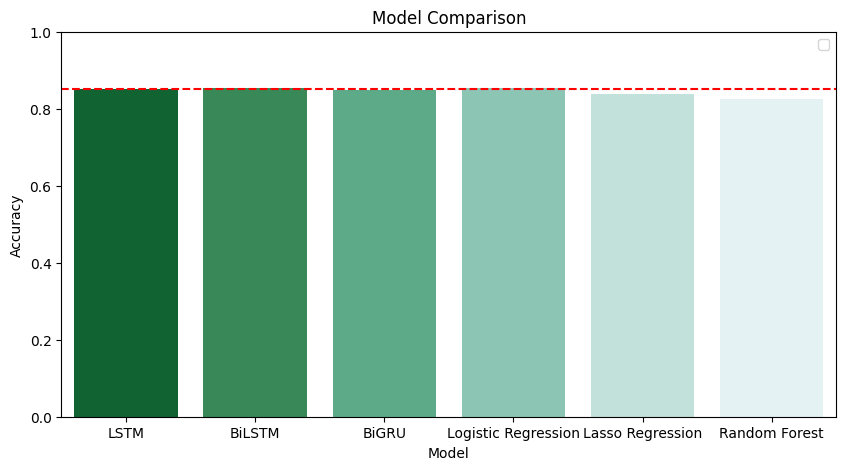

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=results, x='Model', y='Accuracy', palette = 'BuGn_r')
plt.title("Model Comparison")
plt.axhline(y=0.85, color='red', linestyle='--')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [ ]:
best_model_name = results.loc[results['Accuracy'].idxmax()]['Model']
print(f"\nBest performing model: {best_model_name}")


Best performing model: BiLSTM


In [ ]:
best_trained_model = trained_models[best_model_name]

if best_model_name in ["LSTM", "BiLSTM", "BiGRU"]:
    full_data_features = padded
    print(f"Using {best_model_name} to predict sentiment for the full dataset.")
    predictions_proba = best_trained_model.predict(full_data_features)
    df['predicted_label'] = np.argmax(predictions_proba, axis=1)
else:
    full_data_features = vectorizer.transform(df['cleaned_review'])
    print(f"Using {best_model_name} to predict sentiment for the full dataset.")
    df['predicted_label'] = best_trained_model.predict(full_data_features)

Using BiLSTM to predict sentiment for the full dataset.
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
df['predicted_label_text'] = df['predicted_label'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
df['actual_label_text'] = df['label'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

df_for_powerbi = df[['Restaurant', 'Review', 'Rating', 'length', 'predicted_label_text', 'actual_label_text']].copy()

df_for_powerbi.to_csv('sentiment_analysis_data.csv', index=False)